In [1]:
# load modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import pyemma.coordinates
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates import load
pdb=('mpro.pdb')
traj=['mpro01.dcd','mpro02.dcd','mpro03.dcd','mpro04.dcd','mpro06.dcd','mpro05.dcd','mpro07.dcd','mpro08.dcd','mpro09.dcd','mpro10.dcd','mpro11.dcd','mpro12.dcd','mpro13.dcd','mpro14.dcd','mpro15.dcd','mpro16.dcd','mpro17.dcd','mpro06.dcd','mpro18.dcd','mpro19.dcd','mpro20.dcd']
feat=pyemma.coordinates.featurizer(pdb)
selstr="resSeq 3 4 5 6 84 135 141 164 167 171 175 178 179 180 190 195 217 284 285 286 290 291 300 301"
feat.add_backbone_torsions(selstr, cossin=True, periodic=False)
data_dih=pyemma.coordinates.load(traj, features=feat)
data_dih_c=np.concatenate(data_dih)

04-07-20 18:45:35 pyemma.coordinates.data.feature_reader.FeatureReader[0] WARNING  duplicate files/arrays detected


100%|██████████| 20/20 [00:01<00:00, 14.81it/s]                                 


In [2]:
import pandas as pd
data = pd.read_csv('df.txt', sep=",")
data

,Unnamed: 0,IC1,IC2,IC3,pos,a.a,sin/cos,phi/psi
0,0,0.222455,-0.288424,-0.075114,3,PHE,COS,PHI
1,1,-0.167333,0.181811,0.104695,3,PHE,SIN,PHI
2,2,0.143228,-0.467745,-0.341650,3,PHE,COS,PSI
3,3,0.200887,-0.548390,-0.424974,3,PHE,SIN,PSI
4,4,0.199367,-0.355311,-0.339336,4,ARG,COS,PHI
...,...,...,...,...,...,...,...,...
91,91,-0.297391,0.337564,-0.130704,300,CYS,SIN,PSI
92,92,-0.103867,0.074726,0.025310,301,SER,COS,PHI
93,93,-0.019618,-0.049279,-0.049867,301,SER,SIN,PHI
94,94,-0.069346,0.136679,-0.147939,301,SER,COS,PSI


In [3]:
IC1 = 0
for i in range(len(data)):
    IC1  += data['IC1'][i]*data_dih_c[:,i]
print(IC1) 

[-4.0010114 -6.693346  -6.6575966 ... -5.0670466 -4.1136093 -4.28332  ]


In [4]:
IC2 = 0
for i in range(len(data)):
    IC2 += data['IC2'][i]*data_dih_c[:,i]
print(IC2) 

[0.4891138 3.9919424 4.2267723 ... 3.3989716 3.5577424 3.1294425]


In [5]:
tica_output=np.transpose([IC1,IC2])

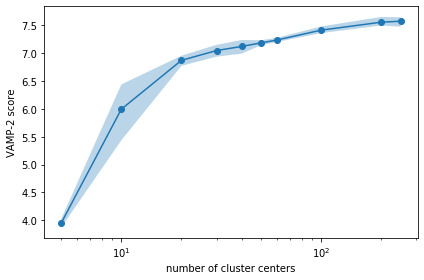

In [6]:
n_clustercenters = [5, 10, 20, 30, 40, 50, 60, 100, 200, 250]

scores = np.zeros((len(n_clustercenters), 10))
for n, k in enumerate(n_clustercenters):
    for m in range(10):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=200, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 10)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

100%|██████████| 14/14 [00:04<00:00,  3.08it/s]                        


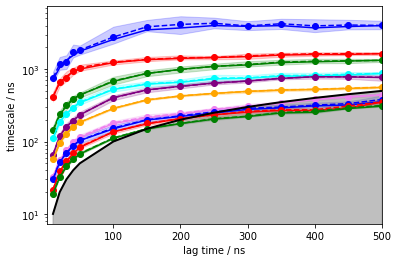

In [7]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=100, max_iter=100, stride=10, fixed_seed=100)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
its = pyemma.msm.its(cluster.dtrajs, lags=[10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], nits=10, errors='bayes')
fig1 = pyemma.plots.plot_implied_timescales(its, units='ns', dt=1)

3744it [00:00, 20398.31it/s]                                                                                                           
100%|██████████| 9/9 [00:07<00:00,  1.19it/s]                        


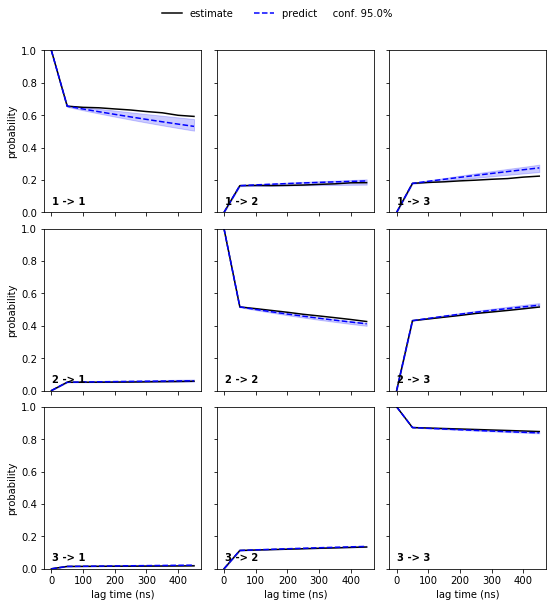

In [8]:
nstates=3
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='1 ns', conf=0.95)
fig2 = pyemma.plots.plot_cktest(msm.cktest(nstates), units='ns');

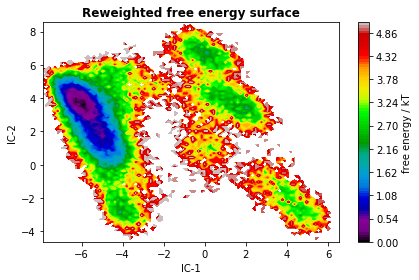

In [9]:
# MSM Free Energy
fig3, ax = pyemma.plots.plot_free_energy(
    *tica_output[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()))
ax.set_xlabel('IC-1')
ax.set_ylabel('IC-2')
ax.set_title('Reweighted free energy surface', fontweight='bold')
fig3.tight_layout()

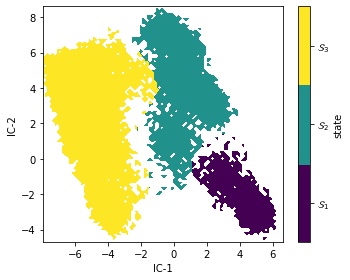

In [10]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig4, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_output[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC-1')
ax.set_ylabel('IC-2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig4.tight_layout()

π_1 = 0.049794
π_2 = 0.148772
π_3 = 0.801434


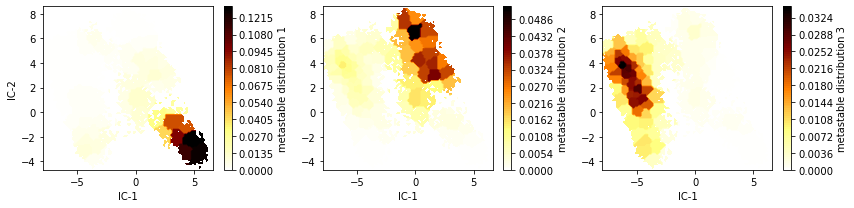

In [11]:
nstates = 3
msm.pcca(nstates)

for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_output.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC-1')
axes[0].set_ylabel('IC-2')
fig.tight_layout()

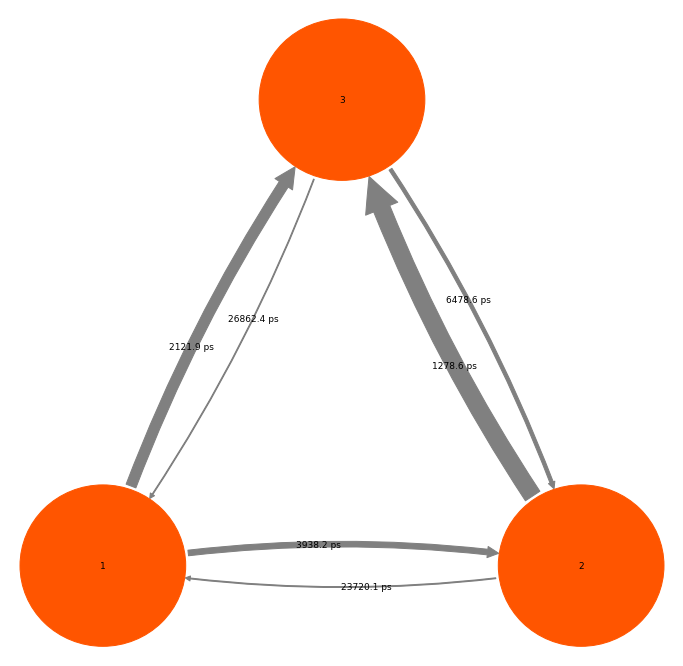

In [12]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[0, 0], [4, 0], [2, 4]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=9);